# Figure 5 - spatial and temporal coupling

In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

import h5py

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from surfplot import Plot

from scipy.spatial.distance import cdist
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder

from util import subject
from util.path import Path
from util.atlas import Atlas  # , get_brainmask
from util.signal import xcorr
from constants import SUBS_STRANGERS, BLU, ORG, TRIAL_SLICES

plt.style.use('figures.mplstyle')

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
modelname = "joint_split"
# modelname = "joint_nosplit"
features = ["confounds", "stats", "acoustic", "articulatory", "LLM"]

# modelname = "llm_split"
# # modelname = "llm_nosplit"
# features = ["confounds", "LLM"]

# for variance partioning:
# modelname = "joint_split_nollm"
# features = ["confounds", "stats", "acoustic", "articulatory"]

suffix = ''
cache = 'default_task'
# cache = 'default_task_trial'

encmodel = f"encoding_{cache}{suffix}"

# # black story
# encmodel = "encoding_black"
# modelname = 'model-gpt2-2b_layer-24'
# features = ["stats", "acoustic", "articulatory", "LLM"]
# # modelname = 'contextual'
# # features = ["stats", "LLM"]

# FG_MASK = get_brainmask()

cachedir = f'results/cache/figure2-{encmodel}/{modelname}/'
resultdir = f'figures/figure2/{encmodel}/{modelname}/'
!mkdir -p $resultdir
!mkdir -p $cachedir

modelname, encmodel, cache, cachedir

('joint_split',
 'encoding_default_task',
 'default_task',
 'results/cache/figure2-encoding_default_task/joint_split/')

In [4]:
catlas = Atlas.load("custom_glasser_group")
len(catlas)

22

In [5]:
lags = np.arange(-10, 11)
lags * 1.5

array([-15. , -13.5, -12. , -10.5,  -9. ,  -7.5,  -6. ,  -4.5,  -3. ,
        -1.5,   0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,
        12. ,  13.5,  15. ])

In [6]:
# ONLY XCORR PROD-COMP CHUNKS

sub_mbc_scores = []

# for subA in tqdm(SUBS_STRANGERS[17:18]):
for subA in tqdm(SUBS_STRANGERS):

    # load subA preds
    encpath = Path(root='results/' + encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        predA = f["cv_preds"][:, -1].reshape(1200, -1)
        prod_mask = f["cv_prod_mask"][...].ravel()
    # prod_boxcar, _, _ = subject.get_timinglog_boxcars(subA)
    # prod_mask = prod_boxcar.astype(bool)

    # load subB preds
    subB = subject.get_partner(subA)
    encpath = Path(root='results/' + encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        nuis_predsB = f["cv_preds"][:, :-1].sum(1).reshape(1200, -1)
    dataB = subject.get_bold(subB, cache=cache)
    resB = dataB - nuis_predsB

    dataA = catlas.vox_to_parc(predA)
    dataB = catlas.vox_to_parc(resB)
    n_rois = len(catlas)

    sub_scores = np.zeros((10, n_rois, n_rois, len(lags)), dtype=np.float32)
    for k, trial_slice in enumerate(TRIAL_SLICES):
        dataA_trial = dataA[trial_slice]
        dataB_trial = dataB[trial_slice]
        pmask_trial = prod_mask[trial_slice]

        all_xcorrs = []
        chunk_bounds = np.diff(pmask_trial, prepend=0).nonzero()[0]
        if pmask_trial.all():
            chunk_bounds = [0, 120]

        if not pmask_trial.any(): # didn't speak at all in this trial
            continue

        for i in range(0, len(chunk_bounds), 2):
            from_idx = chunk_bounds[i] + 1
            to_idx = chunk_bounds[i+1] if i+1 < len(chunk_bounds) else 120

            chunk_size = to_idx - from_idx
            if chunk_size < 7:  # NOTE arbitrary threshold
                continue
            
            # NOTE arbitrary margin
            chunk_slice = slice(max(0, from_idx - 6),
                                min(120, to_idx + 6))

            dataA_chunk = dataA_trial[chunk_slice]
            dataB_chunk = dataB_trial[chunk_slice]

            # loop through each pair of ROIs
            roi_xcorrs = []
            for j in range(n_rois):
                for l in range(n_rois):
                    corrs, _ = xcorr(dataA_chunk[..., j],
                                    dataB_chunk[..., l],
                                    maxlags=len(lags)//2)
                    roi_xcorrs.append(corrs)
            all_xcorrs.append(roi_xcorrs)

        all_xcorrs = np.stack(all_xcorrs)
        all_xcorrs = all_xcorrs.mean(0)
        all_xcorrs = all_xcorrs.reshape(n_rois, n_rois, len(lags))
        sub_scores[k] = all_xcorrs

    sub_mbc_scores.append(sub_scores)

sub_mbc_prod = np.stack(sub_mbc_scores)
sub_mbc_prod.shape

 29%|██▉       | 17/58 [01:10<02:51,  4.17s/it]/scratch/gpfs/zzada/fconv/code/util/signal.py:27: RuntimeWarning: divide by zero encountered in divide
  corr /= np.sqrt(np.dot(x, x) * np.dot(y, y))
/scratch/gpfs/zzada/fconv/code/util/signal.py:27: RuntimeWarning: invalid value encountered in divide
  corr /= np.sqrt(np.dot(x, x) * np.dot(y, y))
100%|██████████| 58/58 [03:59<00:00,  4.13s/it]


(58, 10, 22, 22, 21)

In [ ]:
# old way, probably best to remove
# subA prod pred -> subB comp actual
# by first shifting the signal, then taking out production time points, then correlating

sub_mbc_scores = []

# use subA's predictions on subB's actual neural data
for subA in tqdm(SUBS_STRANGERS):

    # load subA preds
    encpath = Path(root='results/' + encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        predA = f["cv_preds"][:, -1].reshape(1200, -1)
        prodmaskA = f["cv_prod_mask"][...].ravel()

    # load subB preds
    subB = subject.get_partner(subA)
    encpath = Path(root='results/' + encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        nuis_predsB = f["cv_preds"][:, :-1].sum(1).reshape(1200, -1)
    dataB = subject.get_bold(subB, cache=cache)
    resB = dataB - nuis_predsB

    predA = catlas.vox_to_parc(predA)
    resB = catlas.vox_to_parc(resB)

    sub_scores = np.zeros((10, len(lags), len(catlas), len(catlas)), dtype=np.float32)
    for k, t in enumerate(range(0, 1200, 120)):
        trial_slice = slice(t, t+120) 
        predA_trial = predA[trial_slice]
        resB_trial = resB[trial_slice]

        for i, lag in enumerate(lags):
            if lag < 0:
                trialA = predA_trial[:lag]
                trialB = resB_trial[-lag:]
                trialM = prodmaskA[trial_slice][:lag]
            elif lag > 0:
                trialA = predA_trial[lag:]
                trialB = resB_trial[:-lag]
                trialM = prodmaskA[trial_slice][lag:]
            else:
                trialA = predA_trial
                trialB = resB_trial
                trialM = prodmaskA[trial_slice]

            if trialM.any():
                x = trialA[trialM]
                y = trialB[trialM]

                # print(subA, subB, k, trialM.sum(), x.shape, y.shape)
                sub_scores[k, i] = 1 - cdist(x.T, y.T, metric='correlation')

    sub_mbc_scores.append(sub_scores)

sub_mbc_prod = np.stack(sub_mbc_scores)
sub_mbc_prod.shape

In [29]:
output = np.isnan(sub_mbc_prod).nonzero()
np.unique(output)
output

(array([17, 17, 17, ..., 17, 17, 17]),
 array([7, 7, 7, ..., 7, 7, 7]),
 array([ 2,  2,  2, ..., 21, 21, 21]),
 array([ 0,  0,  0, ..., 21, 21, 21]),
 array([ 0,  1,  2, ..., 18, 19, 20]))

In [7]:
# save
with h5py.File(f"{cachedir}/mbc-prod_pred-actual-trial.hdf5", "w") as f:
    f.create_dataset(name="sub_mbc_prod", data=sub_mbc_prod)

In [ ]:
# read
with h5py.File(f"{cachedir}/mbc-prod_pred-actual-trial.hdf5", "r") as f:
    sub_mbc_prod = f["sub_mbc_prod"][...]
sub_mbc_prod.shape

## lag 0 heatmap

In [8]:
lag0id = (lags == 0).nonzero()[0].item()
# lag0sim = sub_mbc_prod[..., lag0id].mean((0,1))
lag0sim = np.nanmean(sub_mbc_prod[..., lag0id], axis=(0,1))
lag0id, lag0sim.shape, lag0sim.min(), lag0sim.max()

(10, (22, 22), -0.04420245, 0.110839)

In [9]:
labels_stripped = [label.removeprefix('LH_').removeprefix('RH_') for label in catlas.labels]

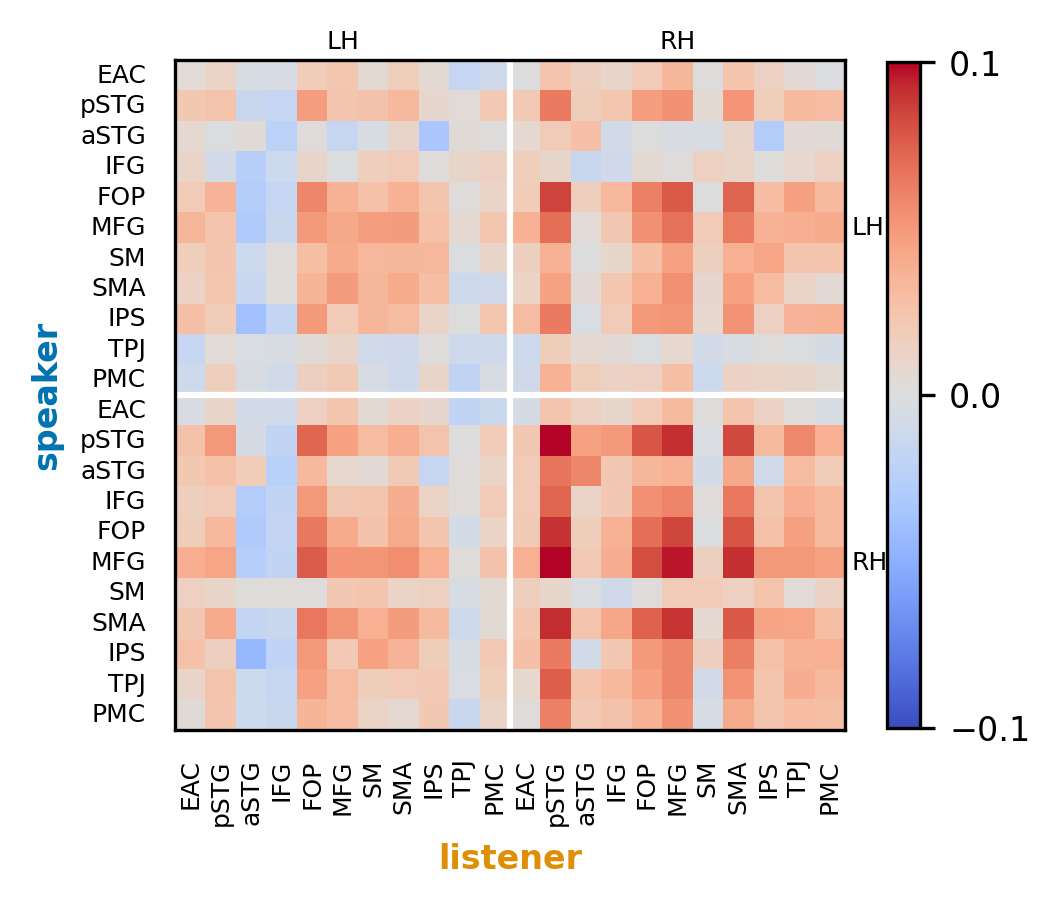

In [61]:
D = lag0sim
fig, ax = plt.subplots(figsize=(3.6, 3.6), dpi=300)

im = ax.imshow(D, cmap="coolwarm", vmin=-0.1, vmax=0.1)

# ax.vlines(edges - 0.5, *ax.get_ylim(), colors="k", alpha=0.25)
# ax.hlines(edges - 0.5, *ax.get_xlim(), colors="k", alpha=0.25)

ax.axvline(len(D) // 2 - 0.5, c="white")
ax.axhline(len(D) // 2 - 0.5, c="white")

ax.tick_params(left=False, bottom=False)
ax.set_xticks(np.arange(22))
ax.set_yticks(np.arange(22))
ax.set_xticklabels(labels_stripped, rotation=90, horizontalalignment="center", fontsize=6)
ax.set_yticklabels(labels_stripped, verticalalignment="center", fontsize=6)

ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

ax.text(0.25, 1.01, "LH", fontsize=6, transform=ax.transAxes, va="bottom", ha="center",)
ax.text(0.75, 1.01, "RH", fontsize=6, transform=ax.transAxes, va="bottom", ha="center",)
ax.text(1.01, 0.25, "RH", fontsize=6, transform=ax.transAxes, va="center", ha="left")
ax.text(1.01, 0.75, "LH", fontsize=6, transform=ax.transAxes, va="center", ha="left")

ax.set_ylabel('speaker', color=BLU, fontweight='bold', fontsize=8)
ax.set_xlabel('listener', color=ORG, fontweight='bold', fontsize=8)

cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cticks = cbar.ax.get_yticks()
cbar.ax.set_yticks((cticks[0], 0, cticks[-1]))
fig.show()

## sorted xcorr

In [11]:
# avg_mbc = sub_mbc_prod.mean((0,1))
avg_mbc = np.nanmean(sub_mbc_prod, axis=(0, 1))
avg_mbc.shape

(22, 22, 21)

In [12]:
np.nanmax(avg_mbc), np.nanmin(avg_mbc)

(0.110839, -0.05043084)

In [13]:
# inter_roi = avg_mbc.reshape(len(lags), -1).T
inter_roi = avg_mbc.reshape(-1, len(lags))
print(inter_roi.shape)
order = inter_roi.argmax(1).argsort()

(484, 21)


In [14]:
flat_labels = []
for label1 in catlas.labels:
    for label2 in catlas.labels:
        flat_labels.append(label1 + '-' + label2)
len(flat_labels)

484

In [15]:
df = pd.DataFrame()
df['label'] = flat_labels
df['spk_hemi'] = df.label.apply(lambda x: x.split('-')[0].split('_')[0])
df['lst_hemi'] = df.label.apply(lambda x: x.split('-')[1].split('_')[0])
df['spk_roi'] = df.label.apply(lambda x: x.split('-')[0].split('_')[1])
df['lst_roi'] = df.label.apply(lambda x: x.split('-')[1].split('_')[1])
df['peak_lag'] = inter_roi.argmax(1)
df['peak_r'] = inter_roi.max(1)
df.sample(10)

,label,spk_hemi,lst_hemi,spk_roi,lst_roi,peak_lag,peak_r
90,LH_FOP-LH_aSTG,LH,LH,FOP,aSTG,2,0.015747
2,LH_EAC-LH_aSTG,LH,LH,EAC,aSTG,6,0.008232
159,LH_SMA-LH_MFG,LH,LH,SMA,MFG,9,0.056313
481,RH_PMC-RH_IPS,RH,RH,PMC,IPS,11,0.026862
359,RH_MFG-LH_SMA,RH,LH,MFG,SMA,11,0.068297
58,LH_aSTG-RH_IFG,LH,RH,aSTG,IFG,8,0.003446
311,RH_IFG-LH_IFG,RH,LH,IFG,IFG,20,0.000933
180,LH_IPS-LH_FOP,LH,LH,IPS,FOP,10,0.049827
398,RH_SMA-LH_aSTG,RH,LH,SMA,aSTG,3,0.020356
340,RH_FOP-LH_PMC,RH,LH,FOP,PMC,10,0.012210


In [16]:
# df.sort_values(['peak_lag', 'spk_hemi', 'spk_roi', 'lst_hemi', 'lst_roi'], inplace=True)
# df.sort_values(['peak_lag', 'spk_roi', 'lst_roi'], inplace=True)
# df.sort_values(['peak_lag', 'lst_roi', 'spk_roi'], inplace=True)
# df.sort_values(['spk_roi', 'lst_roi'], inplace=True)
df.sort_values('peak_lag', inplace=True)

order = df.index.to_numpy()

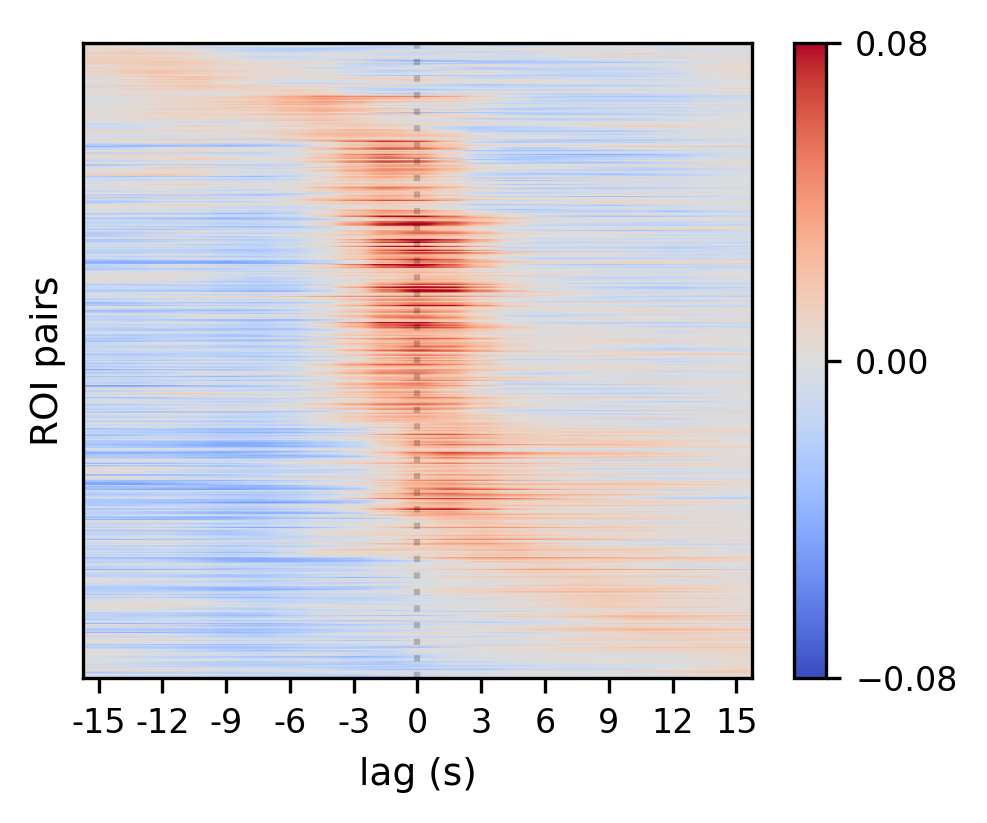

In [64]:
vmax = .08

fig, ax = plt.subplots(figsize=(3.6, 2.75), dpi=300)
im = ax.imshow(inter_roi[order], cmap='coolwarm', aspect='auto', vmin=-vmax, vmax=vmax)
ax.set_yticks([])
ax.set_xticks(range(0, len(lags), 2), labels=(lags[::2] * 1.5).astype(int))
ax.axvline(10, c='k', ls='dotted', alpha=0.2)
# ax.axvline(10-2, c='k', ls='dotted', alpha=0.2)
# ax.axvline(10+2, c='k', ls='dotted', alpha=0.2)
ax.set_xlabel('lag (s)')
ax.set_ylabel('ROI pairs')
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_yticks([-vmax, 0, vmax])

fig.show()

## roi profiles

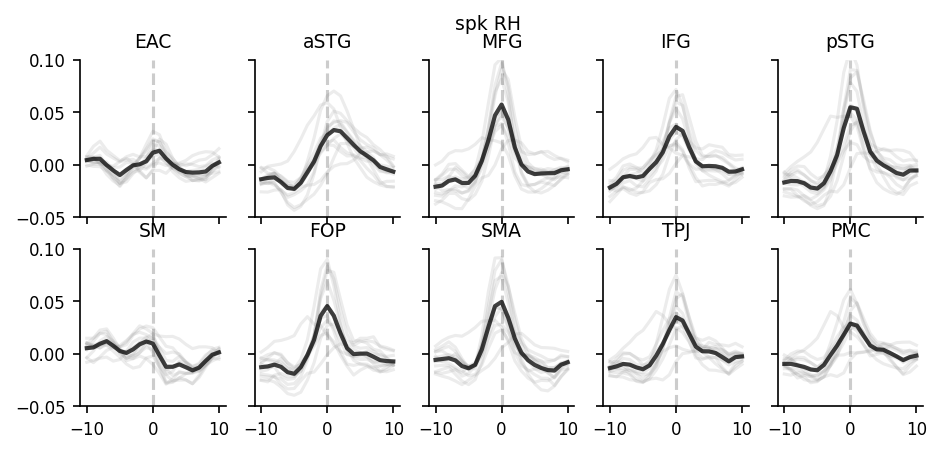

In [72]:
rois = ['EAC', 'aSTG', 'MFG', 'IFG', 'pSTG', 'SM', 'FOP', 'SMA', 'TPJ', 'PMC']

fig, axes = plt.subplots(2, 5, figsize=(7.25, 3), sharex=True, sharey=True)

# role, hemi = 'spk', 'LH'
role, hemi = 'spk', 'RH'
# role, hemi = 'lst', 'LH'
# role, hemi = 'lst', 'RH'

for ax, roi in zip(axes.ravel(), rois):
    subdf = df[(df[f'{role}_roi'] == roi) & (df.spk_hemi == hemi) & (df.lst_hemi == hemi)]
    for i in subdf.index:
        ax.plot(lags, inter_roi[i], c='gray', alpha=0.15)
    ax.plot(lags, np.nanmean(inter_roi[subdf.index], axis=0), c='k', alpha=0.75, lw=2)
    ax.set_title(roi)
    ax.axvline(0, c='k', alpha=0.2, ls='dashed')

ax.set_ylim(-.05, .10)
fig.suptitle(f'{role} {hemi}')
fig.show()

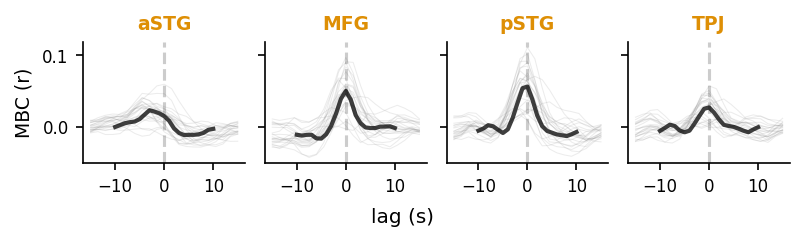

In [26]:
listener_rois = ['aSTG', 'MFG', 'pSTG', 'TPJ']

fig, axes = plt.subplots(1, len(listener_rois), figsize=(5.25, 1.5), sharex=True, sharey=True, layout='constrained')

for ax, roi in zip(axes.ravel(), listener_rois):
    subdf = df[(df.lst_roi == roi) & (df.lst_hemi == 'RH')]
    for i in subdf.index:
        ax.plot(lags * 1.5, inter_roi[i], c='gray', alpha=0.15, lw=0.5)
    ax.plot(lags, inter_roi[subdf.index].mean(0), c='k', alpha=0.75, lw=2)
    ax.set_title(roi, color=ORG, fontweight='bold')
    ax.axvline(0, c='k', alpha=0.2, ls='dashed')
axes[0].set_ylabel('MBC (r)')
fig.supxlabel('lag (s)')
fig.show()

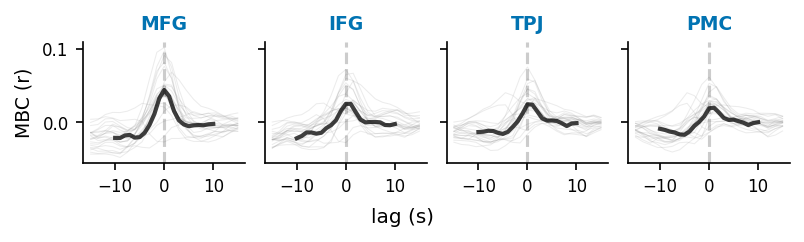

In [27]:
speaker_rois = ['MFG', 'IFG', 'TPJ', 'PMC']

fig, axes = plt.subplots(1, len(speaker_rois), figsize=(5.25, 1.5), sharex=True, sharey=True, layout='constrained')

for ax, roi in zip(axes.ravel(), speaker_rois):
    subdf = df[(df.spk_roi == roi) & (df.spk_hemi == 'RH')]
    for i in subdf.index:
        ax.plot(lags * 1.5, inter_roi[i], c='gray', alpha=0.15, lw=0.5)
    ax.plot(lags, inter_roi[subdf.index].mean(0), c='k', alpha=0.75, lw=2)
    ax.set_title(roi, color=BLU, fontweight='bold')
    ax.axvline(0, c='k', alpha=0.2, ls='dashed')
axes[0].set_ylabel('MBC (r)')
fig.supxlabel('lag (s)')
fig.show()

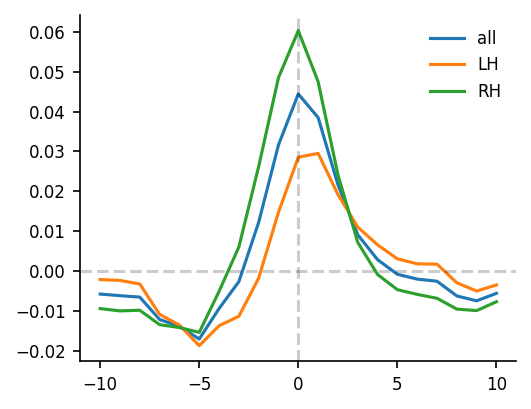

In [137]:
rois = ['EAC', 'aSTG', 'pSTG', 'IFG', 'TPJ', 'MFG']
hemi = 'RH'

fig, ax = plt.subplots(figsize=(3.75, 3))

# for roi in rois:
#     subdf = df[(df.lst_roi == roi) & (df.lst_hemi == hemi)]
#     ax.plot(lags, inter_roi[subdf.index].mean(0), label=roi)

ax.plot(lags, inter_roi.mean(0), label='all')
ax.plot(lags, inter_roi[df[df.lst_hemi == 'LH'].index].mean(0), label='LH')
ax.plot(lags, inter_roi[df[df.lst_hemi == 'RH'].index].mean(0), label='RH')

ax.axvline(0, c='k', alpha=0.2, ls='dashed')
ax.axhline(0, c='k', alpha=0.2, ls='dashed')

ax.legend()

fig.show()

In [99]:
roi = 'pSTG'
roi = 'TPJ'
roi = 'IFG'
roi = 'M1'
roi = 'aSTG'
roi = 'PMC'
subdf = df[(df.spk_roi == roi) & (df.spk_hemi == 'RH')]
subdf.sort_values('peak_r')

,label,spk_hemi,lst_hemi,spk_roi,lst_roi,peak_lag,peak_r
465,RH_PMC-LH_IFG,RH,LH,PMC,IFG,17,0.018927
470,RH_PMC-LH_TPJ,RH,LH,PMC,TPJ,2,0.028167
472,RH_PMC-LH_PMC,RH,LH,PMC,PMC,10,0.041936
478,RH_PMC-RH_M1,RH,RH,PMC,M1,11,0.041996
463,RH_PMC-LH_aSTG,RH,LH,PMC,aSTG,6,0.057436
462,RH_PMC-LH_EAC,RH,LH,PMC,EAC,9,0.059981
473,RH_PMC-RH_EAC,RH,RH,PMC,EAC,9,0.061639
482,RH_PMC-RH_IPS,RH,RH,PMC,IPS,11,0.068791
483,RH_PMC-RH_PMC,RH,RH,PMC,PMC,10,0.071089
471,RH_PMC-LH_IPS,RH,LH,PMC,IPS,11,0.071308


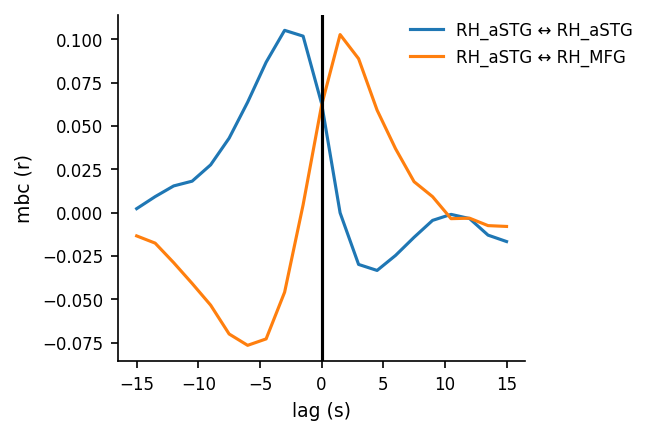

In [85]:
fig, ax = plt.subplots(figsize=(3.5, 3))

for i in [276, 277]:  # aSTG
# for i in [122, 110, 129, 126]:  # M1
# for i in [342, 343, 345]:  # RH_pSTG
# for i in [477, 475, 474]:  # RH_PMC
# for i in [433, 431, 432]:  # RH_TPJ
# for i in [323, 321, 322]:  # RH_IFG
    r, c = np.unravel_index(i, shape=(22, 22))
    label = catlas.labels[r] + ' ↔ ' + catlas.labels[c]
    ax.plot(lags * 1.5, inter_roi[i], label=label)

ax.axvline(0, c='k')
ax.set_xlabel('lag (s)')
ax.set_ylabel('mbc (r)')
ax.legend(bbox_to_anchor=(.7, 1), borderaxespad=0)
fig.show()

## plot individual trajectories

In [82]:
df[(df.peak_lag < 10) & (df.peak_r > .06)].sort_values('peak_r', ascending=False)

,label,spk_hemi,lst_hemi,spk_roi,lst_roi,peak_lag,peak_r
122,LH_MFG-RH_pSTG,LH,RH,MFG,pSTG,9,0.078025
430,RH_IPS-RH_pSTG,RH,RH,IPS,pSTG,9,0.067870
126,LH_MFG-RH_MFG,LH,RH,MFG,MFG,9,0.067814
188,LH_IPS-RH_pSTG,LH,RH,IPS,pSTG,9,0.067351
170,LH_SMA-RH_MFG,LH,RH,SMA,MFG,9,0.065679
166,LH_SMA-RH_pSTG,LH,RH,SMA,pSTG,9,0.062435
125,LH_MFG-RH_FOP,LH,RH,MFG,FOP,9,0.060054


In [83]:
df[(df.peak_lag > 10) & (df.peak_r > .06)].sort_values('peak_r', ascending=False)

,label,spk_hemi,lst_hemi,spk_roi,lst_roi,peak_lag,peak_r
282,RH_pSTG-RH_SMA,RH,RH,pSTG,SMA,11,0.088449
298,RH_aSTG-RH_pSTG,RH,RH,aSTG,pSTG,11,0.070354
359,RH_MFG-LH_SMA,RH,LH,MFG,SMA,11,0.068297
326,RH_IFG-RH_SMA,RH,RH,IFG,SMA,11,0.066840
271,RH_pSTG-LH_SMA,RH,LH,pSTG,SMA,11,0.060733


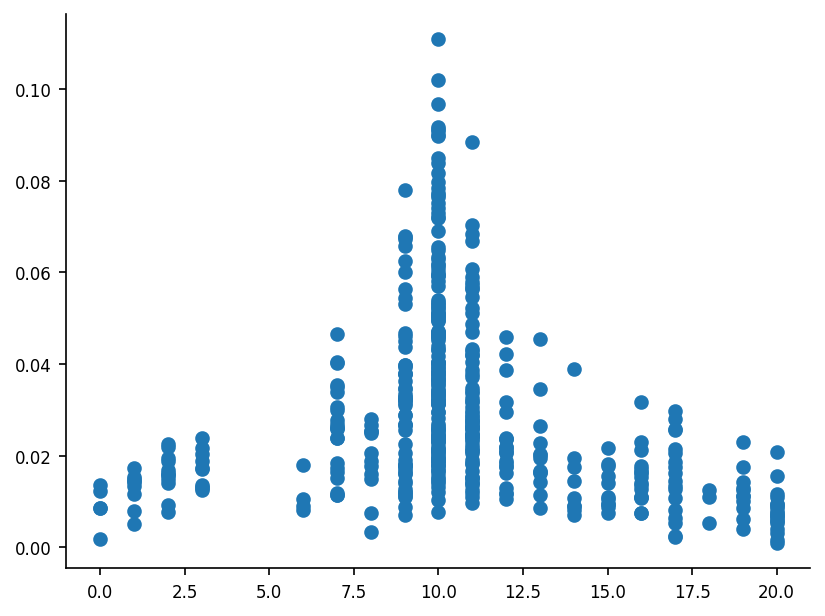

In [79]:
plt.scatter(df.peak_lag, df.peak_r)

In [78]:
df.peak_lag.describe()

count    484.000000
mean      10.679752
std        4.035906
min        0.000000
25%        9.000000
50%       10.000000
75%       12.000000
max       20.000000
Name: peak_lag, dtype: float64

In [76]:
lags

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9,  10])

In [231]:
import plotly.express as px

In [213]:
maxes = inter_roi[order].max(-1)
maxes.shape

(484,)

In [214]:
print(order[maxes[:150].argsort()[-10:]])

print(order[maxes[150:280].argsort()[-10:] + 150])

print(order[maxes[300:].argsort()[-10:] + 300])

[300 388 432 476 456 410 322 256 366 344]
[195 426 413 433 435 411 345 415 349 437]
[363 336 358 341 479 360 338 369 371 347]


In [ ]:
# https://stackoverflow.com/questions/73649907/plotly-express-imshow-hover-text/73658192#73658192
fig = px.imshow(inter_roi[order],
                y=flat_labels,
                aspect='auto',
                color_continuous_scale='RdBu_r',
                height=800,
                )
fig.update_yaxes(showticklabels=False)
fig.show()

In [99]:
catlas.labels[1][3:]

'aSTG'

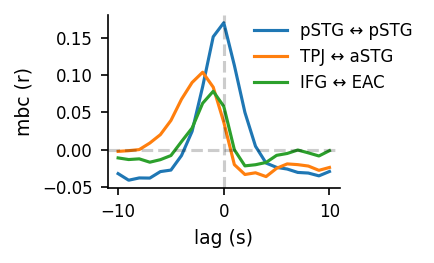

In [120]:
fig, ax = plt.subplots(figsize=(2, 1.5))

# for i in [256, 366, 344]:  # group 1 top 3
# for i in [415, 349, 437]:  # group 2 top 3
# for i in [338, 369, 347]:  # group 2 top 3
# for i in [300, 388, 432, 476, 456, 410, 322, 256, 366, 344]:
# for i in [430, 319, 345, 266]:
for i in [345, 430, 319]:
    r, c = np.unravel_index(i, shape=(22, 22))
    label = catlas.labels[r][3:] + ' ↔ ' + catlas.labels[c][3:]
    ax.plot(lags, inter_roi[i], label=label)

ax.axvline(0, c='k', alpha=0.2, ls='dashed')
ax.axhline(0, c='k', alpha=0.2, ls='dashed')
ax.set_xlabel('lag (s)')
ax.set_ylabel('mbc (r)')
ax.legend(bbox_to_anchor=(.6, 1), borderaxespad=0, ncol=1)
fig.show()

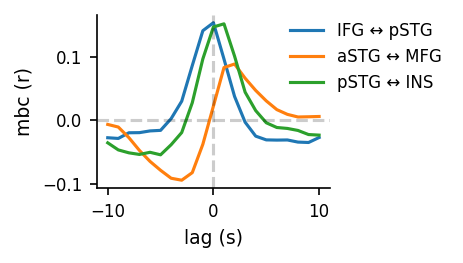

In [127]:
fig, ax = plt.subplots(figsize=(2, 1.5))

for i in [323, 266, 336]:
    r, c = np.unravel_index(i, shape=(22, 22))
    label = catlas.labels[r][3:] + ' ↔ ' + catlas.labels[c][3:]
    ax.plot(lags, inter_roi[i], label=label)

ax.axvline(0, c='k', alpha=0.2, ls='dashed')
ax.axhline(0, c='k', alpha=0.2, ls='dashed')
ax.set_xlabel('lag (s)')
ax.set_ylabel('mbc (r)')
ax.legend(bbox_to_anchor=(.8, 1), borderaxespad=0, ncol=1)
fig.show()

## try clustering

In [31]:
model = NMF(n_components=3, max_iter=1000)
W = model.fit_transform(1 - inter_roi)
H = model.components_
labels = W.argmax(-1)

/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


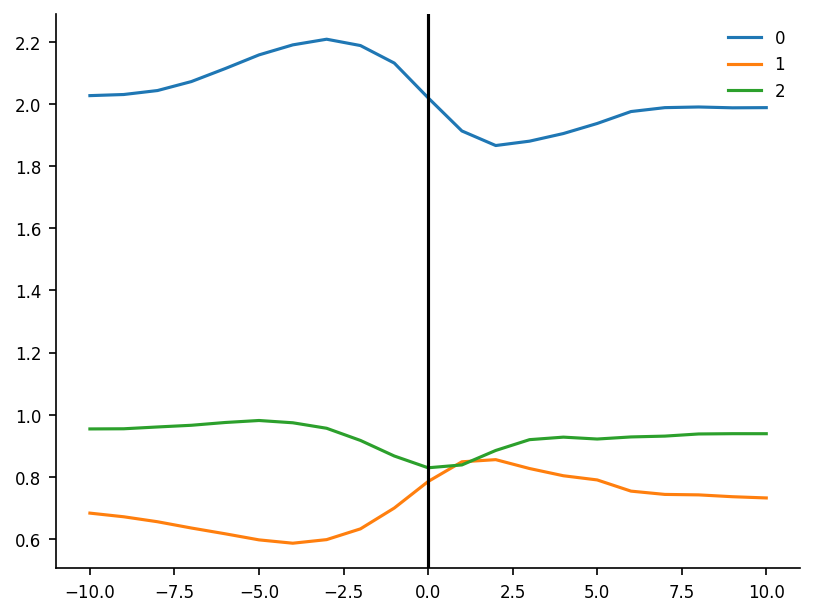

In [35]:
for i in range(model.n_components_):
    plt.plot(lags, H[i], label=i)
plt.axvline(0, c='k')
plt.legend()
plt.show()

## plot label map

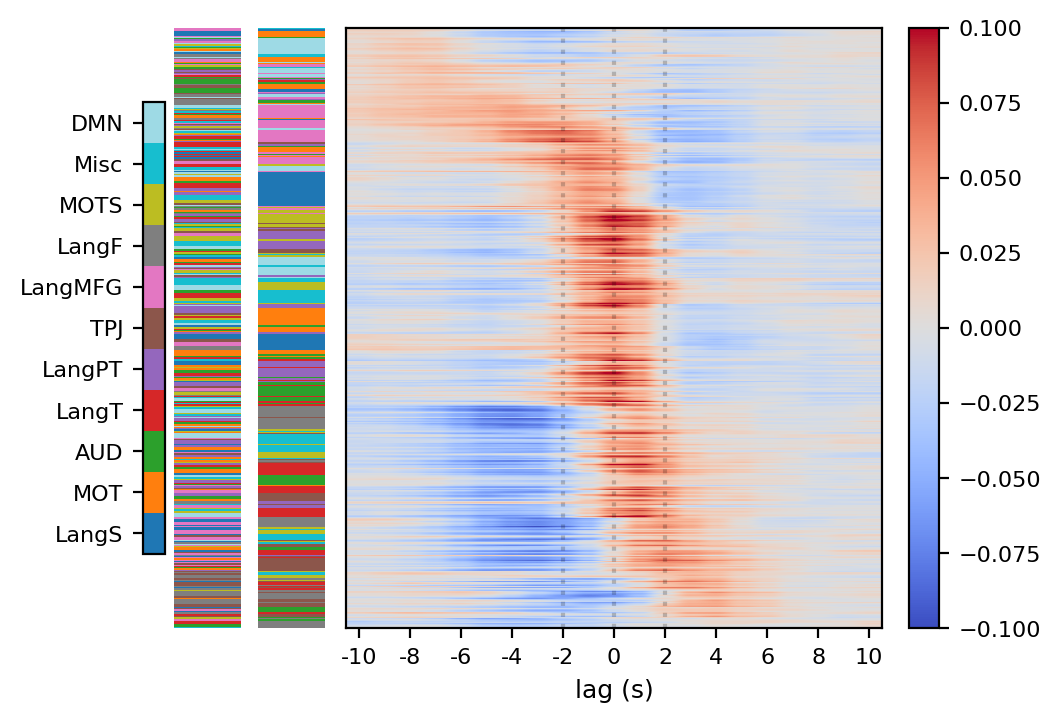

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(5.2, 3.5), width_ratios=[.1, .1, .8], sharey=True, dpi=200, layout='constrained')

colormap = 'tab20'

values = LabelEncoder().fit_transform(df.spk_roi)
ax = axes[0]
cmap = plt.get_cmap(colormap, np.max(values) - np.min(values) + 1)
im = ax.imshow(values.reshape(-1, 1), aspect='auto', cmap=cmap, vmin=values.min()-.5, vmax=values.max()+.5, interpolation='nearest')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])

values = LabelEncoder().fit_transform(df.lst_roi)
ax = axes[1]
cmap = plt.get_cmap(colormap, np.max(values) - np.min(values) + 1)
im = ax.imshow(values.reshape(-1, 1), aspect='auto', cmap=cmap, vmin=values.min()-.5, vmax=values.max()+.5, interpolation='nearest')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])

cbar = fig.colorbar(im, ax=axes[:2], location='left', ticks=np.arange(np.min(values), np.max(values) + 1))
cbar.ax.set_yticklabels([label.split('_')[1] for label in catlas.labels[:11]])

ax = axes[2]
im2 = ax.imshow(inter_roi[order], cmap='coolwarm', vmin=-.1, vmax=.1, aspect='auto', interpolation=None)
ax.set_xticks(range(0, len(lags), 2), labels=lags[::2])
ax.set_yticks([])
ax.axvline(10, c='k', ls='dotted', alpha=0.2)
ax.axvline(10-2, c='k', ls='dotted', alpha=0.2)
ax.axvline(10+2, c='k', ls='dotted', alpha=0.2)
ax.set_xlabel('lag (s)')
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

cbar = fig.colorbar(im2, ax=axes[2])

fig.show()

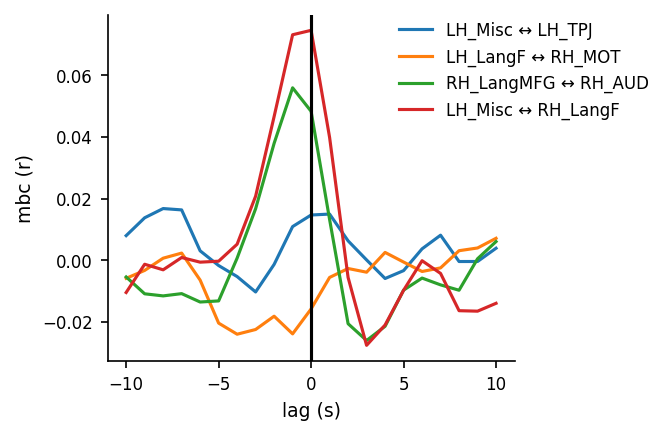

In [122]:
fig, ax = plt.subplots(figsize=(3.5, 3))

# for i in [415, 349, 437]:
# for i in [5, 1, 59]:
# for i in [433, 437, 435]:
# for i in [181, 213, 169]:
for i in [203, 166, 387, 216]:
    r, c = np.unravel_index(i, shape=(22, 22))
    label = catlas.labels[r] + ' ↔ ' + catlas.labels[c]
    ax.plot(lags, inter_roi[i], label=label)

ax.axvline(0, c='k')
ax.set_xlabel('lag (s)')
ax.set_ylabel('mbc (r)')
ax.legend(bbox_to_anchor=(.7, 1), borderaxespad=0)
fig.show()

In [13]:
hemi = 'RH'
seed = 'LangT'
networks = [['AUD', 'LangT', 'LangPT'], ['LangMFG', 'LangF', 'DMN']]

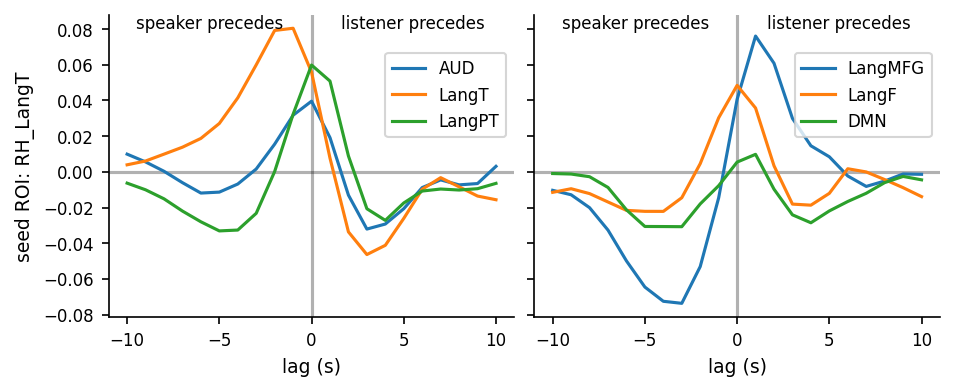

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(6.25, 2.5), sharex=True, sharey=True, layout='constrained')

seedROI = f'{hemi}_{seed}'
seedId = catlas[seedROI] - 1

for ax, nets in zip(axes, networks):
    ax.axvline(0, c="k", alpha=0.3)
    ax.axhline(0, c="k", alpha=0.3)

    for net in nets:
        targetROI = f'{hemi}_{net}'
        targetid = catlas[targetROI] - 1
        values = avg_mbc[:, seedId, targetid]
        ax.plot(lags, values, label=net)
        # print(seedROI, seedId, targetROI, targetid)

    ax.text(0.25, 1, "speaker precedes", transform=ax.transAxes, verticalalignment="top", horizontalalignment="center", fontsize=8)
    ax.text(0.75, 1, "listener precedes", transform=ax.transAxes, verticalalignment="top", horizontalalignment="center", fontsize=8)
    ax.legend(frameon=True, loc='upper right', bbox_to_anchor=(1, 0.9))
    # ax.legend(frameon=True, loc='upper center', ncols=3, bbox_to_anchor=(0.5, -0.2))
    ax.set_xlabel('lag (s)')

axes[0].set_ylabel(f'seed ROI: {seedROI}')

fig.show()

# plot seed ROI

In [98]:
seeds = ['RH_LangPT', 'RH_LangF', 'RH_DMN']

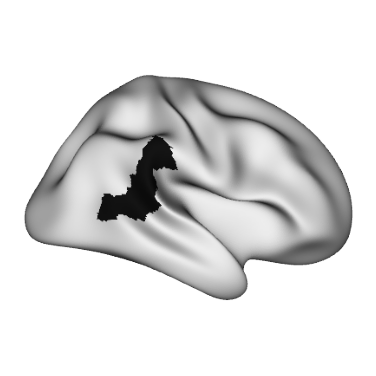

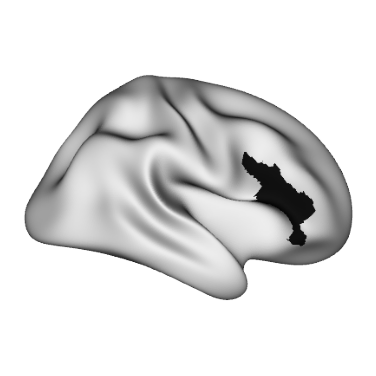

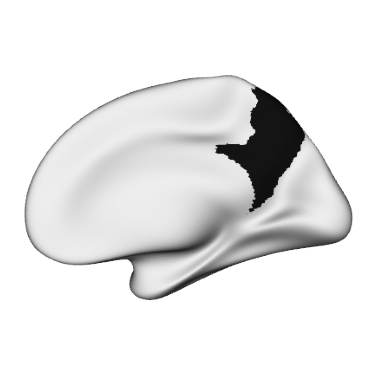

In [122]:
for seed in seeds:
    seedId = catlas[seed]
    roimask = catlas.roimask([seedId]).astype(int)

    view = 'lateral'
    if 'LangS' in seed or 'DMN' in seed:
        view = 'medial'
    # print(seed, seedId, roimask.sum(), view)

    p = Plot(surf_rh="mats/suma-fsaverage6/rh.inf_120.gii", views=view, brightness=0.7, size=(200, 200), zoom=1.2)
    p.add_layer({'right': roimask[roimask.size//2:]}, cmap='Grays', color_range=(0, 1), cbar=False)
    fig = p.build()
    fig.show()

# Misc

In [138]:
!ls results/encoding_t9_run_train/sub-004/joint/

sub-004.hdf5


In [147]:
from himalaya.scoring import correlation_score

In [168]:
# sim between prod and comp
weight_sim_within = []
weight_sim_between = []

respath = Path(
    root='results/' + encmodel + '_run_train',
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

run_weight_sim = np.zeros((len(SUBS_STRANGERS), 5, 22))

for j, subA in enumerate(tqdm(SUBS_STRANGERS)):
    respath.update(sub=f"{subA:03d}")
    with h5py.File(respath, "r") as f:
        weights_prodA = catlas.vox_to_parc(f["cv_weights_prod"][...])
        # weights_compA = catlas.vox_to_parc(f["cv_weights_comp"][...])

    # raw_corrs = correlation_score(weights_prod, weights_comp)
    subB = subject.get_partner(subA)
    respath.update(sub=f"{subB:03d}")
    with h5py.File(respath, "r") as f:
        # weights_prodB = catlas.vox_to_parc(f["cv_weights_prod"][...])
        weights_compB = catlas.vox_to_parc(f["cv_weights_comp"][...])
    
    for i in range(len(weights_prodA)):
        prod2comp = correlation_score(weights_prodA[i], weights_compB[i])
        run_weight_sim[j, i] = prod2comp
        # comp2prod = correlation_score(weights_compA[i], weights_prodB[i])
        # run_weight_sim[j, i] = (prod2comp + comp2prod) / 2


100%|██████████| 58/58 [09:44<00:00, 10.08s/it]


In [170]:
avg_weight_sim = run_weight_sim.mean(0)
avg_weight_sim.shape

(5, 22)

In [175]:
avg_weight_sim.mean(0).argmax()

15

In [183]:
catlas.labels[19]

'RH_TPJ'

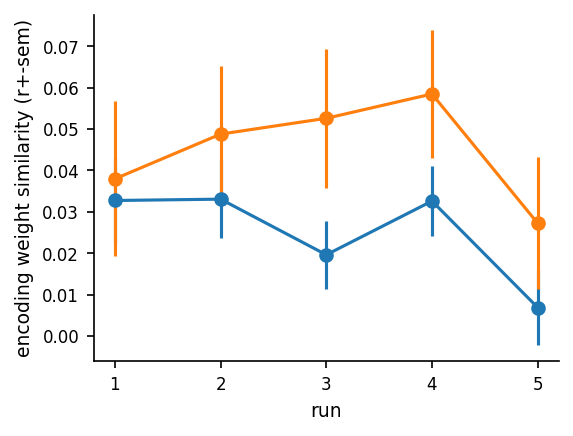

In [186]:
fig, ax = plt.subplots(figsize=(4, 3))
xaxis = np.arange(1, 6)
# for i in range(22):
#     ax.plot(xaxis, avg_weight_sim[:, i], c='gray', alpha=0.3)
ax.errorbar(np.arange(1, 6), avg_weight_sim.mean(-1), yerr=run_weight_sim.mean(-1).std(0) / np.sqrt(58), marker='o')
ax.errorbar(np.arange(1, 6), avg_weight_sim[:, 19], yerr=run_weight_sim[:, :, 19].std(0) / np.sqrt(58), marker='o')
ax.set_xticks(np.arange(1, 6))
ax.set(xlabel='run', ylabel='encoding weight similarity (r+-sem)')
fig.show()

In [154]:
from constants import RUNS, CONV_TRS
from sklearn.model_selection import KFold, PredefinedSplit

In [157]:
run_ids = np.repeat(RUNS, CONV_TRS * 2)
kfold = PredefinedSplit(run_ids)
# kfold = KFold(n_splits=2)
for k, (test_index, train_index) in enumerate(kfold.split(np.empty((2,2)))):
    print(k, train_index[0], train_index[-1])     

0 0 239
1 240 479
2 480 719
3 720 959
4 960 1199
